<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [5]:
!gdown https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
!gdown https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
!gdown https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
!gdown https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK

Downloading...
From: https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
To: /content/sns_val.zip
100% 34.8M/34.8M [00:00<00:00, 45.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
To: /content/sns_train.zip
100% 278M/278M [00:03<00:00, 77.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
To: /content/train.csv
100% 2.24M/2.24M [00:00<00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK
To: /content/test.json
100% 417k/417k [00:00<00:00, 106MB/s]


In [6]:
!unzip -uq "/content/sns_train.zip" -d "/content/sns_data"
!unzip -uq "/content/sns_val.zip" -d "/content/sns_data"

In [7]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 13.4 MB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
     |████████████████████████████████| 67 kB 7.8 MB/s 
     |████████████████████████████████| 596 kB 54.3 MB/s 
     |████████████████████████████████| 6.8 MB 52.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [49]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertForSequenceClassification   #BERT
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification   #RoBerta

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
train_df = pd.read_csv("/content/train.csv")

In [12]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [13]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/일과직업.csv']

In [14]:
df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])

In [15]:
df_all

,0
0,맥주삿당 역시 태풍엔 맥주지\n오 뭐뭐 샀음?\n필라이트 좡색\n오 나는 구스 아일...
1,일단 니 에스쁘아쿠션까지해서 총6개\n에스쁘아쿠션사게?̊̈ ㅋㅋㅋㅋㅋ\n아니 니 어...
2,누리카드사용 낼부터된다네 책을 좀 빨리봐야해서 오늘 그냥주문해줘\n알겠음 집으로 시...
3,언니 텐텐서 컵 살거야? 살 거면 나 테이블보? 무슨 패브릭 이런거 하나만 사게 업...
4,하 어쩌냐 팔기싫다 또 질문해 어찌고저찌고\nㅋㅋㅋㅋㅋㅋㅋ 아 또 뭐래...\n블투...
...,...
107993,#@이름#상\nㅇㅇ?\n나 오늘 교슈한테 그만둔다고 말함\n올ㅋ\nㅋ\n뭐래\n첨엔...
107994,맞아 바로그거\n그래도 와디즈 2년 다니면 잘나가는 스타트업 섬렵한 느낌 나는데\n...
107995,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ머를??ㅋㅋㅋㅋㅋㅋ\n그런척하는겈ㅋㅋㅋㅋㅋㅋㅋ\nㅋㅋㅋㅋㅋㅋㅋㅋㅋ...
107996,공기업아니면\n그 일부가\n경영자본금?\n자기한테잇다던데 지분! 지분 자기한테잇단거...


In [16]:
df_all["class"] = "일반 대화"

In [17]:
df_all.head()

,0,class
0,맥주삿당 역시 태풍엔 맥주지\n오 뭐뭐 샀음?\n필라이트 좡색\n오 나는 구스 아일...,일반 대화
1,일단 니 에스쁘아쿠션까지해서 총6개\n에스쁘아쿠션사게?̊̈ ㅋㅋㅋㅋㅋ\n아니 니 어...,일반 대화
2,누리카드사용 낼부터된다네 책을 좀 빨리봐야해서 오늘 그냥주문해줘\n알겠음 집으로 시...,일반 대화
3,언니 텐텐서 컵 살거야? 살 거면 나 테이블보? 무슨 패브릭 이런거 하나만 사게 업...,일반 대화
4,하 어쩌냐 팔기싫다 또 질문해 어찌고저찌고\nㅋㅋㅋㅋㅋㅋㅋ 아 또 뭐래...\n블투...,일반 대화


In [18]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [19]:
df_all

,conversation,class
0,맥주삿당 역시 태풍엔 맥주지\n오 뭐뭐 샀음?\n필라이트 좡색\n오 나는 구스 아일...,일반 대화
1,일단 니 에스쁘아쿠션까지해서 총6개\n에스쁘아쿠션사게?̊̈ ㅋㅋㅋㅋㅋ\n아니 니 어...,일반 대화
2,누리카드사용 낼부터된다네 책을 좀 빨리봐야해서 오늘 그냥주문해줘\n알겠음 집으로 시...,일반 대화
3,언니 텐텐서 컵 살거야? 살 거면 나 테이블보? 무슨 패브릭 이런거 하나만 사게 업...,일반 대화
4,하 어쩌냐 팔기싫다 또 질문해 어찌고저찌고\nㅋㅋㅋㅋㅋㅋㅋ 아 또 뭐래...\n블투...,일반 대화
...,...,...
107993,#@이름#상\nㅇㅇ?\n나 오늘 교슈한테 그만둔다고 말함\n올ㅋ\nㅋ\n뭐래\n첨엔...,일반 대화
107994,맞아 바로그거\n그래도 와디즈 2년 다니면 잘나가는 스타트업 섬렵한 느낌 나는데\n...,일반 대화
107995,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ머를??ㅋㅋㅋㅋㅋㅋ\n그런척하는겈ㅋㅋㅋㅋㅋㅋㅋ\nㅋㅋㅋㅋㅋㅋㅋㅋㅋ...,일반 대화
107996,공기업아니면\n그 일부가\n경영자본금?\n자기한테잇다던데 지분! 지분 자기한테잇단거...,일반 대화


In [20]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,맥주삿당 역시 태풍엔 맥주지\n오 뭐뭐 샀음?\n필라이트 좡색\n오 나는 구스 아일...
1,일반 대화,일단 니 에스쁘아쿠션까지해서 총6개\n에스쁘아쿠션사게?̊̈ ㅋㅋㅋㅋㅋ\n아니 니 어...
2,일반 대화,누리카드사용 낼부터된다네 책을 좀 빨리봐야해서 오늘 그냥주문해줘\n알겠음 집으로 시...
3,일반 대화,언니 텐텐서 컵 살거야? 살 거면 나 테이블보? 무슨 패브릭 이런거 하나만 사게 업...
4,일반 대화,하 어쩌냐 팔기싫다 또 질문해 어찌고저찌고\nㅋㅋㅋㅋㅋㅋㅋ 아 또 뭐래...\n블투...
...,...,...
107993,일반 대화,#@이름#상\nㅇㅇ?\n나 오늘 교슈한테 그만둔다고 말함\n올ㅋ\nㅋ\n뭐래\n첨엔...
107994,일반 대화,맞아 바로그거\n그래도 와디즈 2년 다니면 잘나가는 스타트업 섬렵한 느낌 나는데\n...
107995,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ머를??ㅋㅋㅋㅋㅋㅋ\n그런척하는겈ㅋㅋㅋㅋㅋㅋㅋ\nㅋㅋㅋㅋㅋㅋㅋㅋㅋ...
107996,일반 대화,공기업아니면\n그 일부가\n경영자본금?\n자기한테잇다던데 지분! 지분 자기한테잇단거...


In [21]:
df_train2 = df_all.sample(n = 900, random_state = 5)

In [22]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1.0,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3.0,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
194938,NaN,일반 대화,#@시스템#사진# 자리있네 아니다 일단 낼 몇시에 올건지 그것부터 말해보세요\n나 ...
155369,NaN,일반 대화,김규종 왜케 잘생겼어?\n나랑 #@이름#은 케빈 창조 개잘생겼다 하고 보고있었음\n...
56572,NaN,일반 대화,나 오늘 혼자 첫 근무 별거아닌데 떨려죽겠네\nㅋㅋㅋㅋㅋ 그래도 점장 중간에 오겠지...
490753,NaN,일반 대화,언니가 7일날에 집으로 오라는데\n7일날에??\n웅 그날 오빠랑 나랑 둘다 안되잖아...


In [23]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
194938,일반 대화,#@시스템#사진# 자리있네 아니다 일단 낼 몇시에 올건지 그것부터 말해보세요\n나 ...
155369,일반 대화,김규종 왜케 잘생겼어?\n나랑 #@이름#은 케빈 창조 개잘생겼다 하고 보고있었음\n...
56572,일반 대화,나 오늘 혼자 첫 근무 별거아닌데 떨려죽겠네\nㅋㅋㅋㅋㅋ 그래도 점장 중간에 오겠지...
490753,일반 대화,언니가 7일날에 집으로 오라는데\n7일날에??\n웅 그날 오빠랑 나랑 둘다 안되잖아...


In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,직장 내 괴롭힘 대화,주말에 뭐하나\n별일없습니다\n잘됐네\n네?\n나 주말에 대학 동기 녀석들이랑 골프...
1,갈취 대화,내가 말한 금액대로 가져왔냐?\n미안해. 못가져왔어.\n뭐라고? 그걸 지금 말이라고...
2,기타 괴롭힘 대화,이거 왜 원플러스원 아니에요?\n고객님 행사가 지난주에 끝났습니다.\n저까지만 원플...
3,직장 내 괴롭힘 대화,어머어머 효정씨 살찐것좀봐\n네?\n아니 업무가 편한가? \n아니요.그건아닌데\n업...
4,일반 대화,우리자기 다 먹으면서 빼고 있으니 다이어트 잘되고 있는듯!\nㅋㅋㅋㅋㅋ아니라구\n네...
...,...,...
4845,기타 괴롭힘 대화,가 안냥하쎄요\n나 안냥하쎄요 . 말투가 이상하시네여 낄낄\n가 네? 남의 말투를 ...
4846,기타 괴롭힘 대화,니네엄마 베트남사람이라면서?\n응\n그럼 너도 베트남사람이야?\n아니 나는 한국사람...
4847,직장 내 괴롭힘 대화,아니 일을 이따위로밖에 못하나?\n네???\n네??? 네?? 지금 대답도 그따위로밖...
4848,기타 괴롭힘 대화,야 애들아 얘 봐 \n헐 쟤 뭐야 징그러워.\n하지마.저리가.\n야 가까이 좀 와봐...


In [25]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [10]:
text = "나븝 밥을\n 먹었다"
text_mod = re.sub('\n'," "+"\n"+" ",text)
print(text_mod)
print(text)

나븝 밥을 
  먹었다
나븝 밥을
 먹었다


In [26]:
df_train["conversation"] = df_train["conversation"].apply(preprocess_sentence)
df_train

,class,conversation
0,직장 내 괴롭힘 대화,주말에 뭐하나 \n 별일없습니다 \n 잘됐네 \n 네 ? \n 나 주말에 대학 동...
1,갈취 대화,내가 말한 금액대로 가져왔냐 ? \n 미안해 . 못가져왔어 . \n 뭐라고 ? ...
2,기타 괴롭힘 대화,이거 왜 원플러스원 아니에요 ? \n 고객님 행사가 지난주에 끝났습니다 . \n...
3,직장 내 괴롭힘 대화,어머어머 효정씨 살찐것좀봐 \n 네 ? \n 아니 업무가 편한가 ? \n 아니요...
4,일반 대화,우리자기 다 먹으면서 빼고 있으니 다이어트 잘되고 있는듯 ! \n ㅋㅋㅋㅋㅋ아니라...
...,...,...
4845,기타 괴롭힘 대화,가 안냥하쎄요 \n 나 안냥하쎄요 . 말투가 이상하시네여 낄낄 \n 가 네 ? 남의...
4846,기타 괴롭힘 대화,니네엄마 베트남사람이라면서 ? \n 응 \n 그럼 너도 베트남사람이야 ? \n ...
4847,직장 내 괴롭힘 대화,아니 일을 이따위로밖에 못하나 ? \n 네 ? ? ? \n 네 ? ? ? 네 ?...
4848,기타 괴롭힘 대화,야 애들아 얘 봐 \n 헐 쟤 뭐야 징그러워 . \n 하지마 . 저리가 . \...


In [27]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df_train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

df_train["class"] = bucket_class
df_train.head()

,class,conversation
0,2,주말에 뭐하나 \n 별일없습니다 \n 잘됐네 \n 네 ? \n 나 주말에 대학 동...
1,1,내가 말한 금액대로 가져왔냐 ? \n 미안해 . 못가져왔어 . \n 뭐라고 ? ...
2,3,이거 왜 원플러스원 아니에요 ? \n 고객님 행사가 지난주에 끝났습니다 . \n...
3,2,어머어머 효정씨 살찐것좀봐 \n 네 ? \n 아니 업무가 편한가 ? \n 아니요...
4,4,우리자기 다 먹으면서 빼고 있으니 다이어트 잘되고 있는듯 ! \n ㅋㅋㅋㅋㅋ아니라...


In [28]:
X = df_train["conversation"].to_list()
Y = df_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4365
y_train 개수 : 4365
x_val 개수 : 242
y_val 개수 : 242
x_test 개수 : 243
y_test 개수 : 243
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 4: 810, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 2: 49, 1: 49, 4: 45, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45, 4: 45})


In [29]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
kbert_tokenizer = BertTokenizer.from_pretrained("klue/bert-base", use_fast=True)
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", use_fast=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [30]:
bert_train_encodings = bert_tokenizer(x_train, truncation=True, padding=True)
bert_val_encodings = bert_tokenizer(x_val, truncation=True, padding=True)

kbert_train_encodings = kbert_tokenizer(x_train, truncation=True, padding=True)
kbert_val_encodings = kbert_tokenizer(x_val, truncation=True, padding=True)

roberta_train_encodings = roberta_tokenizer(x_train, truncation=True, padding=True)
roberta_val_encodings = roberta_tokenizer(x_val, truncation=True, padding=True)

In [31]:
for key in bert_train_encodings:
  print(f"{key} : {bert_train_encodings[key][1]}")

input_ids : [101, 100, 100, 1460, 30010, 30022, 29994, 30014, 29999, 30019, 30023, 100, 1456, 30008, 1017, 29999, 30019, 30022, 29992, 30006, 30022, 29995, 30015, 30005, 30006, 29992, 30017, 30021, 29993, 30009, 30025, 1456, 30006, 100, 1019, 29997, 30019, 30000, 30008, 30021, 29999, 30006, 30021, 29993, 30007, 100, 100, 1029, 1463, 30006, 1456, 30006, 1463, 30006, 30022, 29996, 30006, 1463, 30006, 1464, 30014, 30025, 29999, 30019, 30022, 29999, 30019, 29993, 30017, 30022, 1455, 30006, 29994, 30017, 30001, 30019, 30023, 1463, 30006, 30022, 29996, 30006, 29999, 30008, 29993, 30019, 29997, 30008, 30005, 30007, 1455, 30011, 1469, 30006, 29999, 30019, 29995, 30006, 30003, 30017, 100, 100, 100, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
bert_train_dataset = tf.data.Dataset.from_tensor_slices((dict(bert_train_encodings), 
                                                    y_train))
bert_val_dataset = tf.data.Dataset.from_tensor_slices((dict(bert_val_encodings), 
                                                  y_val))

kbert_train_dataset = tf.data.Dataset.from_tensor_slices((dict(kbert_train_encodings), 
                                                    y_train))
kbert_val_dataset = tf.data.Dataset.from_tensor_slices((dict(kbert_val_encodings), 
                                                  y_val))

robert_train_dataset = tf.data.Dataset.from_tensor_slices((dict(roberta_train_encodings), 
                                                    y_train))
robert_val_dataset = tf.data.Dataset.from_tensor_slices((dict(roberta_val_encodings), 
                                                  y_val))

In [33]:
num_labels = max(df_train["class"]) + 1
kbert_model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
kbert_model.compile(optimizer=optimizer, 
              loss=kbert_model.compute_loss, 
              metrics=['accuracy'])
kbert_model.summary()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 110,621,189
Trainable params: 110,621,189
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

kbert_model.fit(
    kbert_train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
    validation_data=kbert_val_dataset.shuffle(1000).batch(16),
    callbacks = [callback_earlystop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


273/273 [==============================] - 12588s 46s/step - loss: 0.4479 - accuracy: 0.8449 - val_loss: 0.2844 - val_accuracy: 0.8926


In [40]:
model_path = "./model/fine-tuned-klue-bert-base-2"
kbert_model.save_pretrained(model_path)
kbert_tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-bert-base-2/tokenizer_config.json',
 './model/fine-tuned-klue-bert-base-2/special_tokens_map.json',
 './model/fine-tuned-klue-bert-base-2/vocab.txt',
 './model/fine-tuned-klue-bert-base-2/added_tokens.json')

In [41]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-bert-base-2"
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-bert-base-2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-bert-base-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [42]:
predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 243/243 [02:29<00:00,  1.62it/s]


In [45]:
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        45
           1       0.88      0.90      0.89        49
           2       0.98      0.96      0.97        49
           3       0.90      0.80      0.85        55
           4       1.00      1.00      1.00        45

    accuracy                           0.91       243
   macro avg       0.92      0.92      0.92       243
weighted avg       0.92      0.91      0.91       243



In [46]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [47]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
39,당신 가족 내가 가만 둘거 같아 ? \n 제발 저하고만 이야기 나눠주세요 \n 2...,1,0
45,야 . 보이냐 ? 개멋있지 . 오백만원짜리 시계야 . \n 응 . \n 한번 만...,3,1
66,친구야 이따 시험때 답좀 슬쩍 보여주라 . \n 그건 어려울것 같은데 . \n...,0,3
78,학부모님 안녕하세요 . \n 선생님 . 우리 애 성적이 왜 이래요 ? \n ...,3,1
83,너 얼마잇나 \n 그걸 왜 물어 \n 요즘 힘드러서 \n 그래서 ? \n 니 돈 ...,1,3
84,나 임신했어 . \n 뭐 ? ? ? ? ? ? 무슨 소리야 . 갑자기 . \n ...,3,0
85,용돈이 다떨어졌어 돈좀내놔봐 \n 자기야 나도 없어 \n 몇대 맞아봐야 정신차리지 ...,1,0
112,상진아 형이 이번에 부업 하나 하려고 하는데 좀 도와줄래 ? \n 어떤일인데요 ?...,3,2
121,어머 쟤 오늘도 저 옷 입고 왔네 . \n 옷이 저거 밖에 없나 보지 뭐 . 우...,3,0
123,이번에 뇌물 받으신 거 다 알고 있습니다 . \n 그래서 어쩌려고 ? \n 여기...,0,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

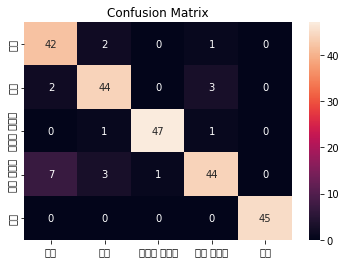

In [50]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [51]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,42,2,0,1,0
갈취,2,44,0,3,0
직장내 괴롭힘,0,1,47,1,0
기타 괴롭힘,7,3,1,44,0
일반,0,0,0,0,45
